# Preliminaries

In [1]:
from gen_recover import *
import matplotlib.pyplot as plt
import math
%matplotlib inline
import numpy as np

In [8]:
# normalized objectives by empirical stdevs
def experiment_histog(moments, stdevs, m):
    k = len(moments)
    from cvxopt import matrix, solvers
    solvers.options['show_progress'] = False
    A = np.zeros((m + 2 * k + 3, m + k + 1))
    B = np.zeros(m + 2 * k + 3)
    C = np.zeros(m + k + 1)
    # set C (optimization)
    for i in xrange(m + 1, m + k + 1):
        C[i] = 1.0
    # set B (constraints)
    B[0] = 1.0
    B[1] = -1.0
    for i in xrange(k):
        B[m + 3 + (2 * i)] = moments[i]
        B[m + 3 + (2 * i) + 1] = -1.0 * moments[i]
    # set A (linear coefficients)
    for i in xrange(m + 1):
        A[0][i] = 1.0
        A[1][i] = -1.0
        A[2 + i][i] = -1.0

    for j in xrange(k):
        A[m + 3 + (2 * j)][m + 1 + j] = -1.0
        A[m + 3 + (2 * j) + 1][m + 1 + j] = -1.0
        for i in xrange(m + 1):
            A[m + 3 + (2 * j)][i] = (((float(i) / float(m))) ** (j + 1))
            A[m + 3 + (2 * j) + 1][i] = (-1.0 * ((float(i) / float(m))) ** (j + 1))
    # print A
    G = matrix(np.ndarray.tolist(np.transpose(A)))
    h = matrix(np.ndarray.tolist(B))
    weights = np.zeros(m + k + 1)
    for i in xrange(k):
        weights[m + i + 1] = 1.0 / (stdevs[i] ** 2)
    P = matrix(np.ndarray.tolist(np.diag(weights)))
    q = matrix(np.ndarray.tolist(np.zeros(m + k + 1)))
    # print B
    # print C
    #sol = solvers.lp(matrix(np.ndarray.tolist(C)), matrix(np.ndarray.tolist(A)), matrix(np.ndarray.tolist(B)))
    sol = solvers.qp(P, q, G, h)
    #print np.dot(C, np.asarray(sol['x']))
    return sol['x']

In [3]:
def moments_stdevs(samples, k):
    n, s = samples.shape
    counts = np.sum(samples, axis=1)
    mom_dist = [np.asarray([float(comb(counts[j], i)) / float(comb(s, i)) for j in xrange(n)]) for i in xrange(1, k + 1)]
    moments = [np.mean(mom) for mom in mom_dist]
    stdevs = [np.std(mom) / math.sqrt(n) for mom in mom_dist]
    return moments, stdevs

def moments_stdevs_stacked(samples, k):
    moments = []
    stdevs = []
    for i in xrange(1, k + 1):
        mom_dist = np.asarray([float(comb(row[1], i)) / float(comb(row[0], i)) for row in samples if (row[0] >= i)])
        moments.append(np.mean(mom_dist))
        stdevs.append(np.std(mom_dist) / math.sqrt(len(mom_dist)))
    return moments, stdevs

def cdf(mesh):
    return np.cumsum(mesh)

In [4]:
def cdf_distro(sample_ps, granularity):
    ss = sorted(sample_ps)
    cdf = np.zeros(granularity + 1)
    for p in ss:
        cdf[int(p * granularity) + 1 : granularity + 1] += np.ones(granularity - int(p * granularity))
    cdf /= float(len(ss))
    return cdf

def isint(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

# Curry

In [5]:
shooting_dict_3p_sc = {}
for i in xrange(13, 18):
    reg = np.loadtxt("Curry/" + str(i) + "reg.csv", skiprows=1, delimiter=',', dtype='str')
    shooting_dict_3p_sc[(i, "reg")] = np.asarray([[int(row[11]), int(row[10])] for row in reg if isint(row[10])])
    poff = np.loadtxt("Curry/" + str(i) + "poff.csv", skiprows=1, delimiter=',', dtype='str')
    shooting_dict_3p_sc[(i, "poff")] = np.asarray([[int(row[11]), int(row[10])] for row in poff if isint(row[10])])

In [6]:
stacked_samples_all_sc = np.asarray([[0, 0]])
for key in shooting_dict_3p_sc:
    stacked_samples_all_sc = np.concatenate((stacked_samples_all_sc, shooting_dict_3p_sc[key]), axis=0)
stacked_samples_all_sc = stacked_samples_all_sc[1:]

iteration 0
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -1.0026e+00  2e+03  3e+01  5e+01
 1:  1.3642e-03 -1.0377e+00  6e+01  8e-01  1e+00
 2:  1.4285e-03 -9.4988e-01  8e+00  1e-01  2e-01
 3:  5.2156e-03 -7.4623e-01  4e+00  3e-02  5e-02
 4:  1.8886e-02 -2.9060e-01  1e+00  1e-02  2e-02
 5:  3.5697e-02 -9.4277e-02  1e+00  6e-03  1e-02
 6:  5.8167e-02  2.3019e-02  8e-01  4e-03  6e-03
 7:  6.6328e-02  8.7149e-02  7e-01  3e-03  5e-03
 8:  1.0820e-01  2.0796e-01  6e-01  2e-03  3e-03
 9:  1.3859e-01  2.5943e-01  5e-01  1e-03  2e-03
10:  2.4649e-01  3.7915e-01  5e-01  9e-04  1e-03
11:  3.7609e-01  4.3126e-01  4e-01  5e-04  7e-04
12:  4.1557e-01  4.4010e-01  3e-01  4e-04  6e-04
13:  4.5109e-01  4.5205e-01  3e-01  3e-04  4e-04
14:  4.6095e-01  4.9547e-01  2e-01  2e-04  3e-04
15:  4.4402e-01  7.1932e-01  2e-01  1e-04  2e-04
16:  4.7651e-01  9.7915e-01  3e-01  1e-04  2e-04
17:  7.7544e-01  3.7974e-01  6e-01  1e-04  2e-04
18:  7.6514e-01  4.0854e-01  5e-01  1e-04  2e-04
19:  7.71

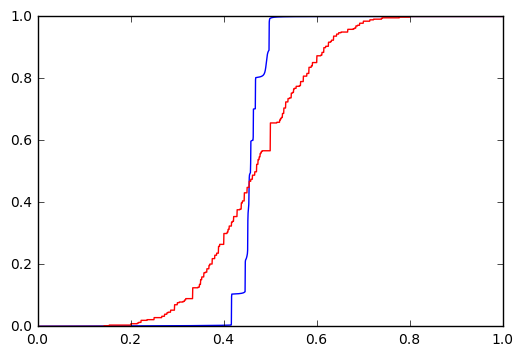

In [7]:
total_cdf = np.zeros((2001, 1))
n = len(stacked_samples_all_sc)
for i in xrange(10):
    print "iteration " + str(i)
    m, s = moments_stdevs_stacked(stacked_samples_all_sc[i * (n / 10) : (i + 1) * (n / 10)], 8)
    nonzero = len(m)
    if 0.0 in m:
        nonzero = m.index(0.0)
    x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
    total_cdf += np.asarray(x[:2001])
total_cdf /= 10.0
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
empirical_ps = np.asarray([(float(row[1]) / float(row[0])) for row in stacked_samples_all_sc])
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color='blue')
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color='red')

# Danny Green

In [9]:
shooting_dict_3p_dg = {}
for i in xrange(12, 18):
    reg = np.loadtxt("Danny/" + str(i) + "reg.csv", skiprows=1, delimiter=',', dtype='str')
    shooting_dict_3p_dg[(i, "reg")] = np.asarray([[int(row[11]), int(row[10])] for row in reg if isint(row[10])])
    poff = np.loadtxt("Danny/" + str(i) + "poff.csv", skiprows=1, delimiter=',', dtype='str')
    shooting_dict_3p_dg[(i, "poff")] = np.asarray([[int(row[11]), int(row[10])] for row in poff if isint(row[10])])

In [10]:
stacked_samples_all_dg = np.asarray([[0, 0]])
for key in shooting_dict_3p_dg:
    stacked_samples_all_dg = np.concatenate((stacked_samples_all_dg, shooting_dict_3p_dg[key]), axis=0)
stacked_samples_all_dg = stacked_samples_all_dg[1:]

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


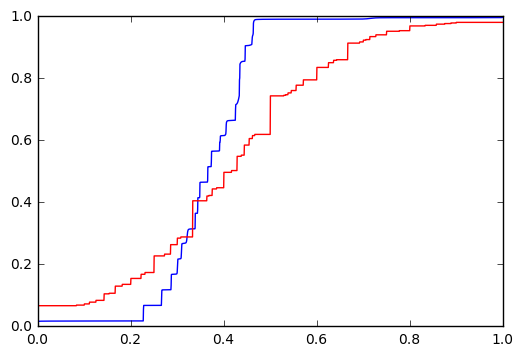

In [13]:
total_cdf = np.zeros((2001, 1))
n = len(stacked_samples_all_dg)
for i in xrange(20):
    print "iteration " + str(i)
    m, s = moments_stdevs_stacked(stacked_samples_all_dg[i * (n / 20) : (i + 1) * (n / 20)], 8)
    nonzero = len(m)
    if 0.0 in m:
        nonzero = m.index(0.0)
    x = experiment_histog(m[:nonzero], s[:nonzero], 2000)
    total_cdf += np.asarray(x[:2001])
total_cdf /= 20.0
x_mesh = np.linspace(0, 1, 2001)
y_mesh = cdf(total_cdf)
empirical_ps = np.asarray([(float(row[1]) / float(row[0])) for row in stacked_samples_all_dg if row[0] != 0])
axes = plt.gca()
axes.set_ylim([0.0, 1.0])
plt.plot(x_mesh, y_mesh, color='blue')
plt.plot(x_mesh, cdf_distro(empirical_ps, 2000), color='red')